---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [62]:
import pandas as pd
import numpy as np
#import seaborn as sn
#import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from adspy_shared_utilities import plot_feature_importances
from sklearn.preprocessing import LabelEncoder

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2827: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


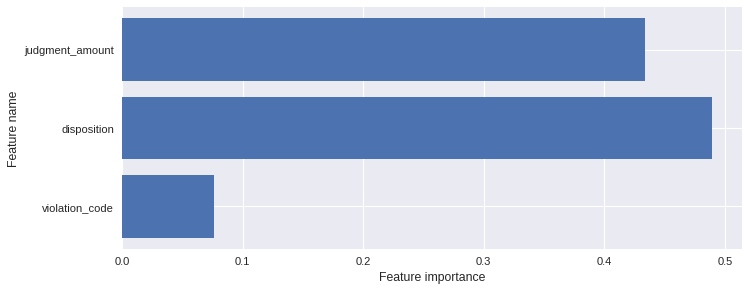

Grid best parameter (max. accuracy):  {'max_depth': 10, 'n_estimators': 100}
Grid best score (accuracy):  0.799408416789
(61001,)


ticket_id
284932    0.154750
285362    0.013018
285361    0.055574
285338    0.044667
285346    0.079305
285345    0.044667
285347    0.054104
285342    0.834054
285530    0.013018
284989    0.018796
285344    0.050050
285343    0.013018
285340    0.013018
285341    0.050050
285349    0.079305
285348    0.044667
284991    0.018796
285532    0.018796
285406    0.018796
285001    0.017103
285006    0.007652
285405    0.013018
285337    0.018796
285496    0.050050
285497    0.044667
285378    0.013018
285589    0.018796
285585    0.044667
285501    0.055574
285581    0.013018
            ...   
376367    0.027354
376366    0.035659
376362    0.183241
376363    0.356996
376365    0.027354
376364    0.035659
376228    0.035659
376265    0.035659
376286    0.327934
376320    0.035659
376314    0.035659
376327    0.327934
376385    0.327934
376435    0.010975
376370    0.930481
376434    0.054104
376459    0.076231
376478    0.005168
376473    0.035659
376484    0.016453
376482    0.023876
37

In [74]:
def blight_model():
    
    # Your code here
    train = pd.read_csv('train.csv',encoding = 'ISO-8859-1')
    test = pd.read_csv('test.csv',encoding = 'ISO-8859-1')
    
    train = train.set_index(train['ticket_id'])
    test = test.set_index(test['ticket_id'])
    
    train = train.dropna(subset = ['compliance'])
    
    le = LabelEncoder()
    le.fit(train['violation_code'].append(test['violation_code']))
    train['violation_code'] = le.transform(train['violation_code'])
    test['violation_code'] = le.transform(test['violation_code'])
    
    le2 = LabelEncoder()
    le2.fit(train['disposition'].append(test['disposition']))
    train['disposition'] = le2.transform(train['disposition'])
    test['disposition'] = le2.transform(test['disposition'])
    
    features = ['violation_code', 'disposition', 'judgment_amount']
    X = train[features]
    y = train['compliance']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    test = test[features]
    
    rfr = RandomForestRegressor().fit(X_train, y_train)
    
    #plt.figure(figsize=(10,4), dpi=80)
    #plot_feature_importances(rfr, features)
    #plt.show()
    
    grid_values = {'n_estimators': [10, 100], 'max_depth': [None, 10]}
    grid = GridSearchCV(rfr, param_grid = grid_values, scoring = 'roc_auc')
    grid.fit(X_train, y_train)
    #print('Grid best parameter (max. accuracy): ', grid.best_params_)
    #print('Grid best score (accuracy): ', grid.best_score_)
    
    predict = grid.predict(test)
    s = pd.Series(predict, index = test.index)
    #print(s.shape)
    
    return s

blight_model()

In [30]:
#blight_model()